# Importing Required Libraries

In [ ]:
# Importing Required Libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt

# Importing and Analyzing the Sataset

In [ ]:
# Import files from your computer
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving labeledTrainData.tsv to labeledTrainData (1).tsv
Saving testData.tsv to testData (1).tsv
Saving unlabeledTrainData.tsv to unlabeledTrainData (1).tsv
User uploaded file "labeledTrainData.tsv" with length 33556378 bytes
User uploaded file "testData.tsv" with length 32724746 bytes
User uploaded file "unlabeledTrainData.tsv" with length 67281491 bytes


In [ ]:
# Import the dataset
movie_reviews_labeled = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

movie_reviews_unlabeled = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

test_data = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)

In [ ]:
# Convert .tsv file to .csv file and read the csv file 
movie_reviews_labeled.to_csv('movie_reviews_labeled.csv')
movie_reviews = pd.read_csv('movie_reviews_labeled.csv')

In [ ]:
# Remove quotations from string and print first 5 rows of the dataset
movie_reviews['review'] = movie_reviews['review'].str.strip('" "')
movie_reviews.head()

,Unnamed: 0,id,sentiment,review
0,0,"""5814_8""",1,With all this stuff going down at the moment w...
1,1,"""2381_9""",1,"\""The Classic War of the Worlds\"" by Timothy H..."
2,2,"""7759_3""",0,The film starts with a manager (Nicholas Bell)...
3,3,"""3630_4""",0,It must be assumed that those who praised this...
4,4,"""9495_8""",1,Superbly trashy and wondrously unpretentious 8...


In [ ]:
# Take a look at any one of the reviews
movie_reviews['review'][0]

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally sta

In [ ]:
# See the size of positive and negative sentiments in this dataset
movie_reviews.shape

(25000, 4)

From the output, it is clear that the dataset contains equal number of positive and negative reviews.

# Data preprocessing

In [ ]:
# Take a text string as a parameter
# Performs preprocessing on the string to remove special chracters from the string

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
# Preprocess our reviews and will store them in a new list as shown below
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

X[0]

'With all this stuff going down at the moment with MJ ve started listening to his music watching the odd documentary here and there watched The Wiz and watched Moonwalker again Maybe just want to get certain insight into this guy who thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent Moonwalker is part biography part feature film which remember going to see at the cinema when it was originally released Some of it has subtle messages about MJ feeling towards the press and also the obvious message of drugs are bad kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for minutes or so excluding th

In [ ]:
y = movie_reviews['sentiment']

In [ ]:
# Divide the dataset into 80% for training set and 20% for testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Preparing the Embedding Layer

In [ ]:
# Prepare the embedding layer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Find the vocabulary size and then perform padding on both train and test set
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
!wget nlp.stanford.edu/data/glove.6B.zip

Saving glove.6B.100d.txt to glove.6B.100d (1).txt


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

In [ ]:
# Load the GloVe word embeddings
# Create a dictionary that will contain words as keys and their corresponding embedding list as values.
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
# Create an embedding matrix where each row number will correspond to the index of the word in the corpus
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Text Classification with Simple Neural Network

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          6766600   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 6,776,601
Trainable params: 10,001
Non-trainable params: 6,766,600
_________________________________________________________________
None


In [ ]:
# Train the model
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
125/125 [==============================] - 2s 9ms/step - loss: 0.6891 - acc: 0.5919 - val_loss: 0.5765 - val_acc: 0.6950
Epoch 2/6
125/125 [==============================] - 1s 6ms/step - loss: 0.5030 - acc: 0.7606 - val_loss: 0.5536 - val_acc: 0.7130
Epoch 3/6
125/125 [==============================] - 1s 5ms/step - loss: 0.4410 - acc: 0.8080 - val_loss: 0.5506 - val_acc: 0.7178
Epoch 4/6
125/125 [==============================] - 1s 6ms/step - loss: 0.4115 - acc: 0.8191 - val_loss: 0.5542 - val_acc: 0.7172
Epoch 5/6
125/125 [==============================] - 1s 6ms/step - loss: 0.3829 - acc: 0.8390 - val_loss: 0.5631 - val_acc: 0.7210
Epoch 6/6
125/125 [==============================] - 1s 6ms/step - loss: 0.3591 - acc: 0.8525 - val_loss: 0.5682 - val_acc: 0.7190


In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

157/157 [==============================] - 0s 2ms/step - loss: 0.5567 - acc: 0.7280


In [ ]:
# Check the test accuracy and loss
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5567067265510559
Test Accuracy: 0.7279999852180481


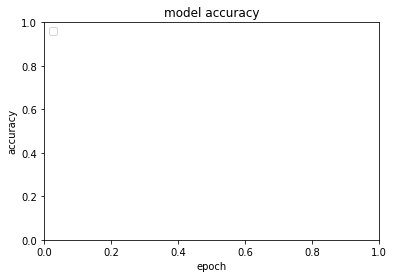

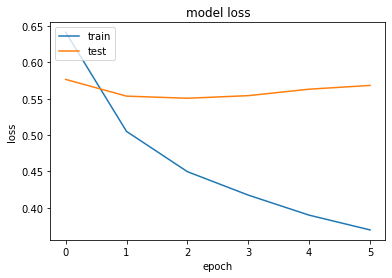

In [ ]:
# Plot the loss and accuracy differences for training and test sets
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

### Text Classification with a Convolutional Neural Network

In [ ]:
# Create a simple convolutional neural network with 1 convolutional layer and 1 pooling layer
from keras.layers.convolutional import Conv1D
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          6766600   
_________________________________________________________________
conv1d (Conv1D)              (None, 100, 128)          64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,830,857
Trainable params: 64,257
Non-trainable params: 6,766,600
_________________________________________________________________
None


In [ ]:
# Train our model and evaluate it on the training set
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
125/125 [==============================] - 13s 101ms/step - loss: 0.6049 - acc: 0.6676 - val_loss: 0.4641 - val_acc: 0.7788
Epoch 2/6
125/125 [==============================] - 13s 100ms/step - loss: 0.4036 - acc: 0.8183 - val_loss: 0.4063 - val_acc: 0.8123
Epoch 3/6
125/125 [==============================] - 13s 101ms/step - loss: 0.3289 - acc: 0.8661 - val_loss: 0.3893 - val_acc: 0.8250
Epoch 4/6
125/125 [==============================] - 13s 102ms/step - loss: 0.2834 - acc: 0.8894 - val_loss: 0.3819 - val_acc: 0.8245
Epoch 5/6
125/125 [==============================] - 13s 102ms/step - loss: 0.2519 - acc: 0.9072 - val_loss: 0.3784 - val_acc: 0.8273
Epoch 6/6
157/157 [==============================] - 2s 11ms/step - loss: 0.3677 - acc: 0.8344


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.36770933866500854
Test Accuracy: 0.8343999981880188


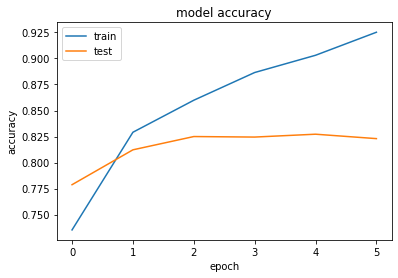

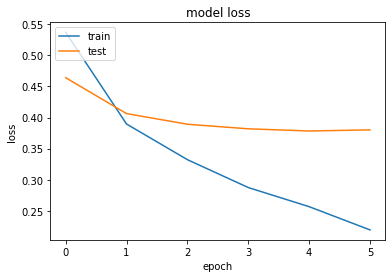

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

### Text Classification with Recurrent Neural Network (LSTM)

In [ ]:
# Use an LSTM (Long Short Term Memory network)
from keras.layers import LSTM

model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          6766600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 6,883,977
Trainable params: 117,377
Non-trainable params: 6,766,600
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
125/125 [==============================] - 45s 343ms/step - loss: 0.6633 - acc: 0.5850 - val_loss: 0.5273 - val_acc: 0.7350
Epoch 2/6
125/125 [==============================] - 42s 337ms/step - loss: 0.4993 - acc: 0.7575 - val_loss: 0.4583 - val_acc: 0.7793
Epoch 3/6
125/125 [==============================] - 43s 342ms/step - loss: 0.4821 - acc: 0.7683 - val_loss: 0.4455 - val_acc: 0.7895
Epoch 4/6
125/125 [==============================] - 42s 338ms/step - loss: 0.4315 - acc: 0.7986 - val_loss: 0.4269 - val_acc: 0.8027
Epoch 5/6
125/125 [==============================] - 42s 336ms/step - loss: 0.4034 - acc: 0.8157 - val_loss: 0.4285 - val_acc: 0.8098
Epoch 6/6
157/157 [==============================] - 5s 34ms/step - loss: 0.3739 - acc: 0.8358


In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.3739152252674103
Test Accuracy: 0.8357999920845032


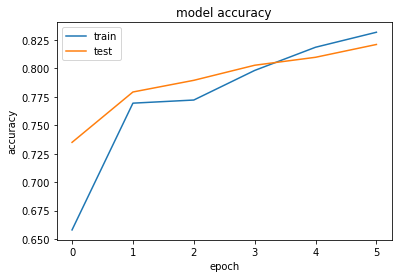

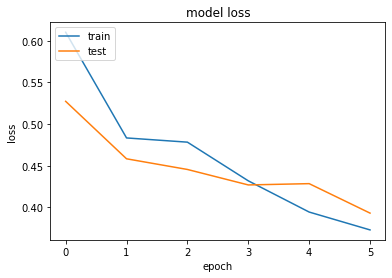

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Making Predictions on Single Instance

In [ ]:
# Select a review from our corpus
instance = X[57]
print(instance)

What stunning episode for this fine series This is television excellence at its best The story takes place in and it beautifully filmed in black white almost film noir style with its deep shadows and stark images This is story about two men who fall in love but don want to spoil this It is rare presentation of what homosexuals faced in the in America Written by the superb Tom Pettit and directed by the great Jeannot Szwarc we move through their lives their love for each other and their tragedy Taking on such sensitive issue makes this episode all the more stunning Our emotions are as torn and on edge as the characters Chills ran up my spine at the end when they played Bob Dylan gorgeous Ah but was so much older then m younger than that now as sung by the Byrds This one goes far past and all the way to the stars Beautiful 


In [ ]:
# Convert this review into numeric form to predict the sentiment
instance = tokenizer.texts_to_sequences(instance)

flat_list = []
for sublist in instance:
    for item in sublist:
        flat_list.append(item)

flat_list = [flat_list]

instance = pad_sequences(flat_list, padding='post', maxlen=maxlen)

model.predict(instance)

array([[0.8541479]], dtype=float32)

The sentiment is predicted as positive.